In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import ccxt
from datetime import datetime, timedelta

import mplfinance as mpf

In [14]:

def read_gateio_price(
    symbol: str = "BTC/USDT",
    day_range: int = 10,
    timeframe: str = "1h",
    as_tw_tz: bool = True,
):
    """Fetches historical price data for Crypto from Binance exchange."""
    # Connect to Binance exchange
    exchange = ccxt.gateio()

    current_time = datetime.now()
    # Calculate the timestamp from days ago
    past_time = current_time - timedelta(days=day_range)

    # Convert timestamps to milliseconds cuz exchange.fetch_ohlcv() requires timestamp in milliseconds
    since = int(past_time.timestamp() * 1000)

    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since)

    df = pd.DataFrame(
        ohlcv, columns=[f"time_{timeframe}", "open", "high", "low", "close", "volume"]
    )

    # Convert the timestamp from milliseconds to a readable date format
    df[f"time_{timeframe}"] = pd.to_datetime(df[f"time_{timeframe}"], unit="ms")

    # Set the timestamp as the DataFrame's index
    df.set_index(f"time_{timeframe}", inplace=True)
    if as_tw_tz:
        df.index = df.index + timedelta(
            hours=8
        )  # Convert to Taiwan timezone if as taiwan timezone set to True

    df.insert(0, "symbol", symbol)

    return df


df = read_gateio_price(symbol="BTC/USDT", day_range=5, timeframe="15m", as_tw_tz=True)
# df.shape
df.tail(20)

,symbol,open,high,low,close,volume
time_15m,,,,,,
2024-05-03 09:30:00,BTC/USDT,59438.6,59500.4,59375.8,59422.3,62.842556
2024-05-03 09:45:00,BTC/USDT,59422.3,59442.8,59243.9,59318.5,86.864152
2024-05-03 10:00:00,BTC/USDT,59318.5,59841.6,59269.0,59753.4,122.042050
2024-05-03 10:15:00,BTC/USDT,59758.5,59910.9,59604.9,59604.9,125.180500
2024-05-03 10:30:00,BTC/USDT,59601.6,59720.5,59514.8,59558.9,59.202770
2024-05-03 10:45:00,BTC/USDT,59559.0,59625.7,59516.3,59546.3,25.291467
2024-05-03 11:00:00,BTC/USDT,59546.4,59828.1,59512.6,59826.6,59.207720
2024-05-03 11:15:00,BTC/USDT,59826.6,59995.9,59705.0,59735.1,95.990260
2024-05-03 11:30:00,BTC/USDT,59735.1,59837.8,59693.1,59788.4,77.194070


In [15]:
def viz_crypto_seaborn(df):
    symbol = df.iloc[0, 0]
    plt.figure(figsize=(12, 5))
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=df, x=df.index, y="close", color="blue", label="Close Price")

    # Find the index of the highest and lowest close price
    max_close_price_idx = df["close"].idxmax()
    min_close_price_idx = df["close"].idxmin()

    # Plot the highest and lowest close price
    plt.scatter(
        [max_close_price_idx], [df["close"][max_close_price_idx]], color="green"
    )
    plt.scatter([min_close_price_idx], [df["close"][min_close_price_idx]], color="red")

    # Add text next to the hight and low points
    plt.text(
        max_close_price_idx,
        df["close"][max_close_price_idx] * 1.001,
        f"Max: {df['close'][max_close_price_idx]}",
        fontsize=8,
    )
    plt.text(
        min_close_price_idx,
        df["close"][min_close_price_idx] * 0.999,
        f"Min: {df['close'][min_close_price_idx]}",
        fontsize=8,
    )

    plt.title(f"{symbol} Close Price")
    plt.xlabel(df.index.name.capitalize().replace("_", " "))
    plt.ylabel("Close Price (USDT)")
    plt.xticks(rotation=0)
    plt.legend()
    plt.show()


def viz_crypto_plotly(df):
    symbol = df.iloc[0, 0]

    fig = px.line(
        df,
        x=df.index,
        y="close",
        title=f"{symbol} Close Price",
        labels={
            df.index.name: df.index.name.capitalize().replace("_", " "),
            "close": "Close Price (USDT)",
        },
    )
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()


def viz_candle(df):
    symbol = df.iloc[0, 0]
    mpf.plot(
        df,
        type="candle",
        style="charles",
        title=f"{symbol} Price",
        ylabel="Price (USDT)",
    )


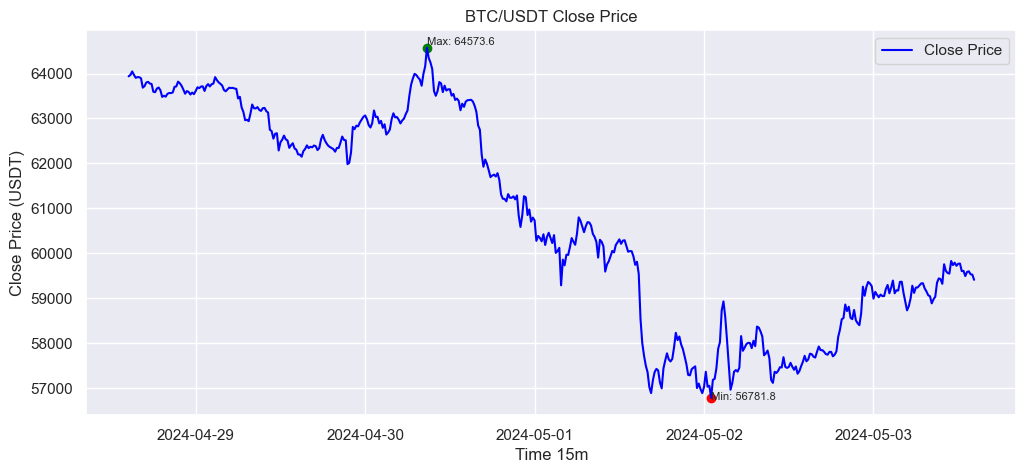

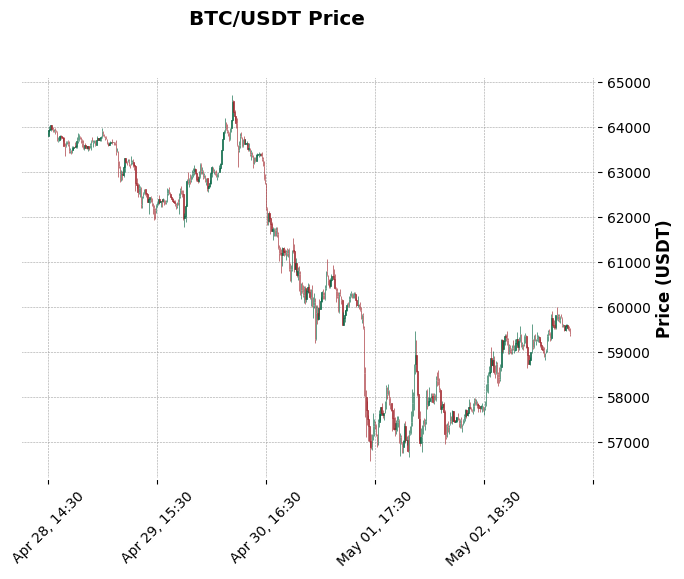

In [16]:
viz_crypto_seaborn(df)
viz_crypto_plotly(df)
viz_candle(df)

In [17]:
print('Symbol:', df.iloc[0, 0])
print(f'from {df.index.min()} to {df.index.max()}')
print(f"Timeframe: {df.index.name.replace('time_', '')}\n")
print(df.describe())

Symbol: BTC/USDT
from 2024-04-28 14:30:00 to 2024-05-03 14:15:00
Timeframe: 15m

               open          high           low         close      volume
count    480.000000    480.000000    480.000000    480.000000  480.000000
mean   60765.185208  60884.687708  60627.053542  60755.895417   96.242039
std     2352.820580   2316.652691   2382.645430   2349.442263   97.621218
min    56781.800000  57001.200000  56573.900000  56781.800000    0.227030
25%    58698.925000  58880.500000  58494.325000  58698.125000   27.969310
50%    60461.650000  60629.400000  60344.400000  60443.900000   61.204145
75%    63101.400000  63161.675000  62954.375000  63073.875000  135.348752
max    64580.100000  64721.500000  64340.500000  64573.600000  604.127242


Up: 229 Down: 251


Text(0.5, 0, 'Close - Open')

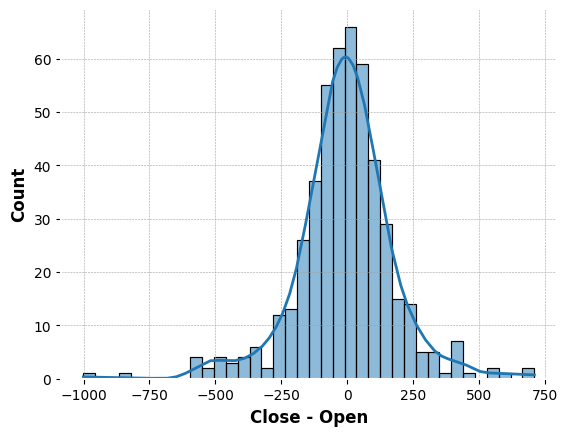

In [18]:
df['diff'] = df.close - df.open
print('Up:', (df['diff'] >= 0).sum(), 'Down:', (df['diff'] < 0).sum())
sns.histplot(df['diff'], kde=True)
plt.xlabel('Close - Open')

<Axes: xlabel='diff', ylabel='Count'>

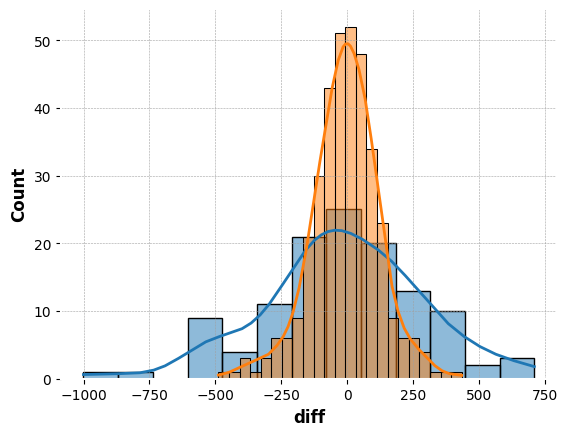

In [19]:
sns.histplot(df[df.volume > 135.348752]['diff'], kde=True)
sns.histplot(df[df.volume < 135.348752]['diff'], kde=True)

count     480.000000
mean      257.634167
std       180.402722
min         9.500000
25%       143.100000
50%       206.900000
75%       318.100000
max      1555.200000
Name: high_low_diff, dtype: float64


<Axes: xlabel='high_low_diff', ylabel='Count'>

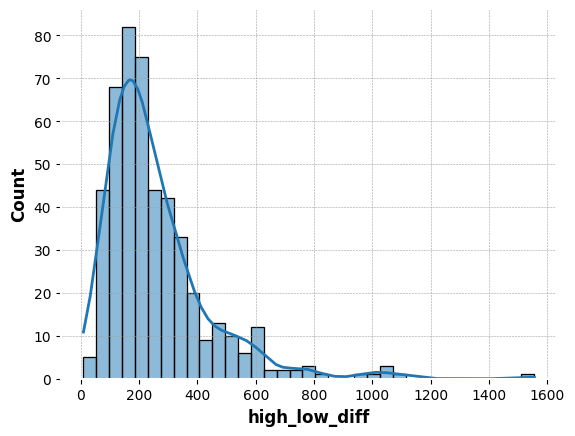

In [20]:
df['high_low_diff'] = df.high - df.low
print(df.high_low_diff.describe())
sns.histplot(df['high_low_diff'], kde=True)

<Axes: xlabel='volume', ylabel='Count'>

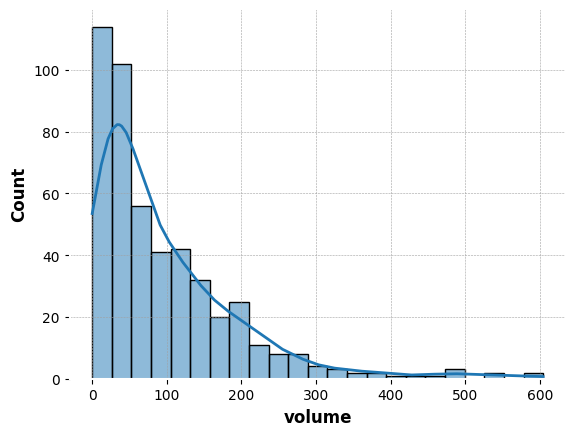

In [21]:
sns.histplot(df['volume'], kde=True)

<Axes: >

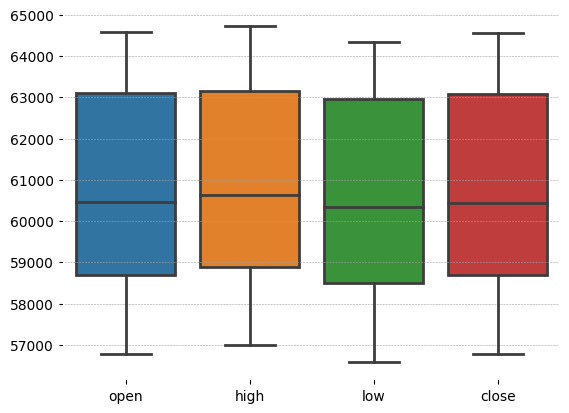

In [22]:
sns.boxplot(data=df[["open", "high", "low", "close"]])
# sns.despine(offset=10, trim=True)

<Axes: xlabel='close', ylabel='Count'>

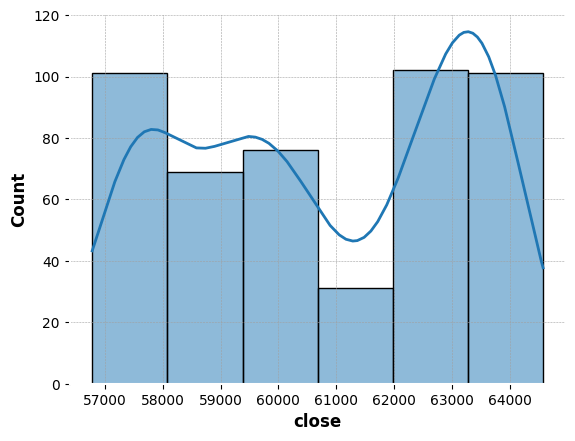

In [23]:
IQR = np.percentile(df['close'], 75) - np.percentile(df['close'], 25)

# Freedman-Diaconis Rule
binwidth = 2 * IQR / np.cbrt(len(df['close']))
bins = int(np.ptp(df['close']) / binwidth)
sns.histplot(df['close'], bins=bins, kde=True)

<Axes: xlabel='close', ylabel='Count'>

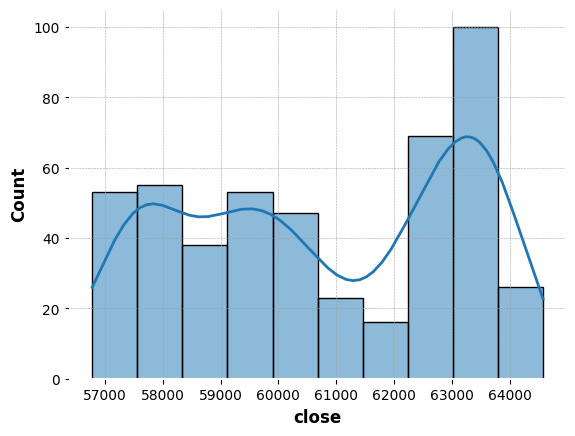

In [24]:
sns.histplot(df['close'], kde=True)

In [25]:
# df['rate'] = ((df['close'] - df['open']) / df['open']).round(3) * 100

# df